# Comparing different arrangement models

This jupyter notebook is to demenstrate a comparison between different spatial arrangement models: independent and deep-MRF models. In the implementation, we have total four training options to compare. **(1)** The pure independent arrangement model trained on un-smoothed data generated from emission model; **(2)** The independent arragement model trained on smoothed data; **(3)** The cmp-RBM arrangement model with free weights W; **(4)** The cmp-RBM arrangement model with constrained weights W.

The main porpuse of this work is trying to compare the parcellation recovery performance when dealing with the synthetic fMRI dataset that contains spatial structures.
<br>

In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from test_arrangement import *

## Data smoothing (kernel size=3, sigma=1)

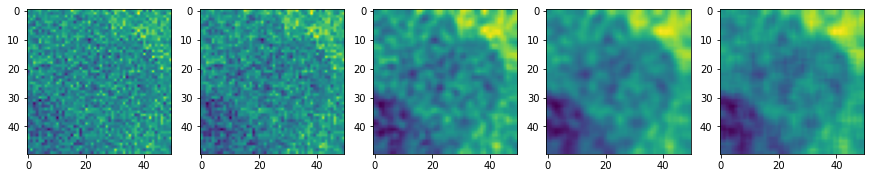

In [16]:
width=50
P = width * width
emissionM = em.MixGaussian(5, 10, P)
emissionM.sigma2 = pt.tensor(0.2)
Ytrain,Ytest,Utrue,Mtrue,grid = make_cmpRBM_data(width=width, K=5, N=10, num_subj=10, theta_mu=180, theta_w=1.2,
                                                 emission_model=emissionM, do_plot=0)

 # Get the smoothed training data
blur_transform1 = transforms.GaussianBlur(kernel_size=5, sigma=0.5)
blur_transform2 = transforms.GaussianBlur(kernel_size=5, sigma=1)
blur_transform3 = transforms.GaussianBlur(kernel_size=5, sigma=1.5)
blur_transform4 = transforms.GaussianBlur(kernel_size=5, sigma=2)

Ytrain_smooth1 = blur_transform1(Ytrain.view(Ytrain.shape[0],-1,width,width)).view(Ytrain.shape[0],Ytrain.shape[1],-1)
Ytrain_smooth2 = blur_transform2(Ytrain.view(Ytrain.shape[0],-1,width,width)).view(Ytrain.shape[0],Ytrain.shape[1],-1)
Ytrain_smooth3 = blur_transform3(Ytrain.view(Ytrain.shape[0],-1,width,width)).view(Ytrain.shape[0],Ytrain.shape[1],-1)
Ytrain_smooth4 = blur_transform4(Ytrain.view(Ytrain.shape[0],-1,width,width)).view(Ytrain.shape[0],Ytrain.shape[1],-1)

plt.figure(figsize=(15,3))
plt.subplot(1, 5, 1)
plt.imshow(Ytrain[0,0,:].reshape(50,50).cpu().numpy())
plt.subplot(1, 5, 2)
plt.imshow(Ytrain_smooth1[0,0,:].reshape(50,50).cpu().numpy())
plt.subplot(1, 5, 3)
plt.imshow(Ytrain_smooth2[0,0,:].reshape(50,50).cpu().numpy())
plt.subplot(1, 5, 4)
plt.imshow(Ytrain_smooth3[0,0,:].reshape(50,50).cpu().numpy())
plt.subplot(1, 5, 5)
plt.imshow(Ytrain_smooth4[0,0,:].reshape(50,50).cpu().numpy())
plt.show()

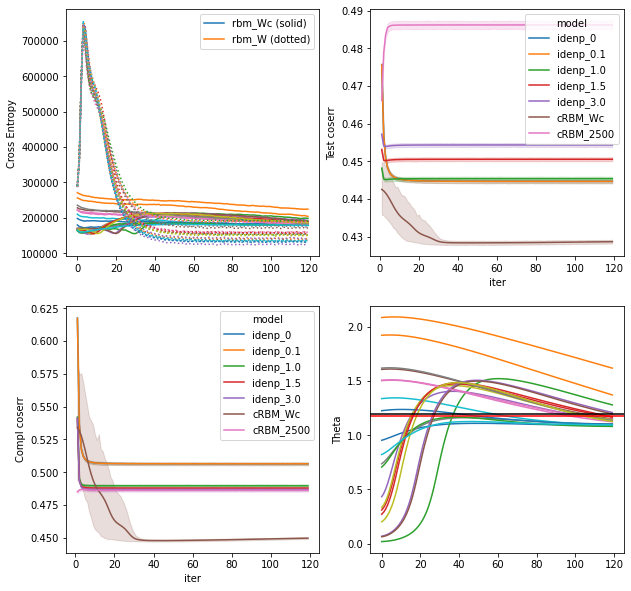

In [2]:
grid, DD, records, rbm, Models, Utrue, emloglik_train, GM, IM = simulation_2(theta_mu=240, num_sim=20)

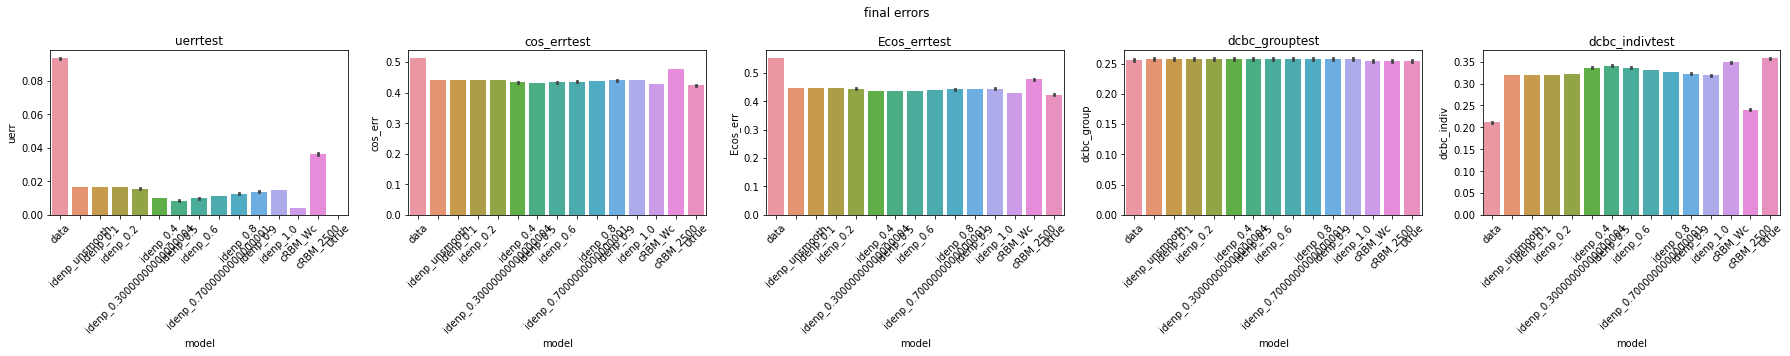

In [3]:
plot_evaluation(DD, types=['test'])

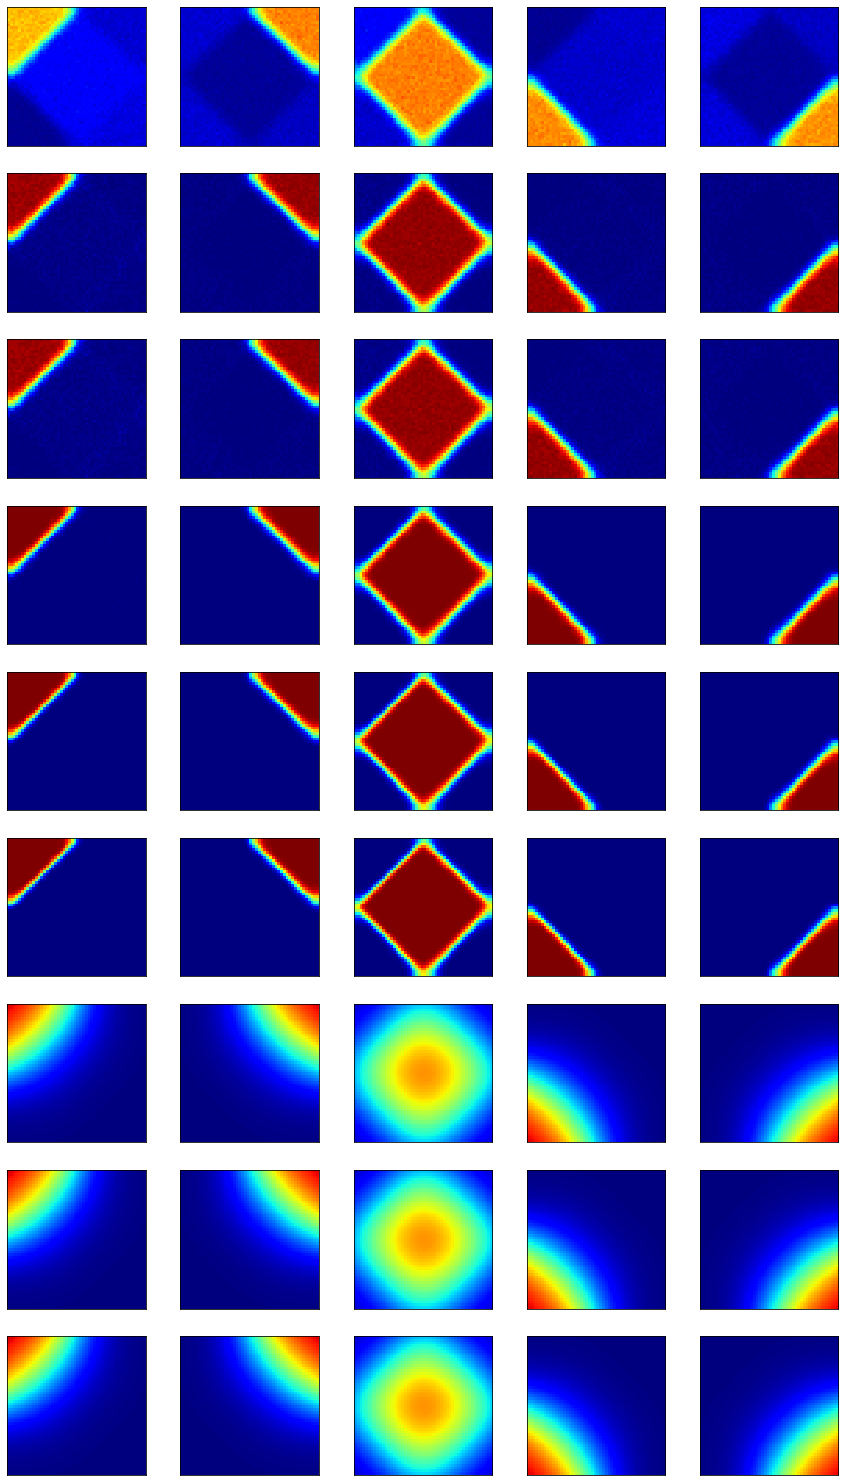

In [4]:
plot_P_maps(pt.cat((records.mean(dim=1), pt.softmax(rbm.bu, 0).unsqueeze(0)), dim=0), grid)

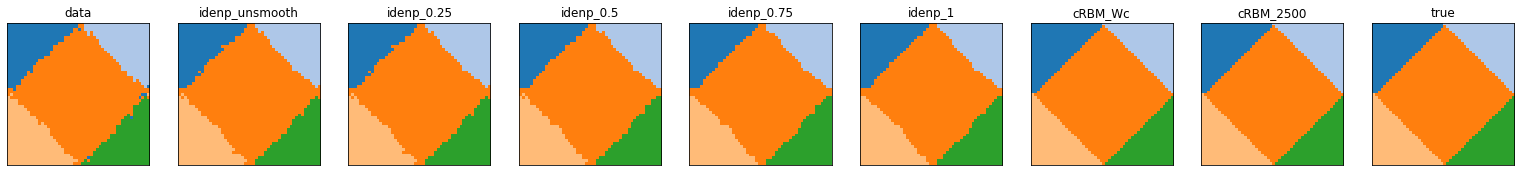

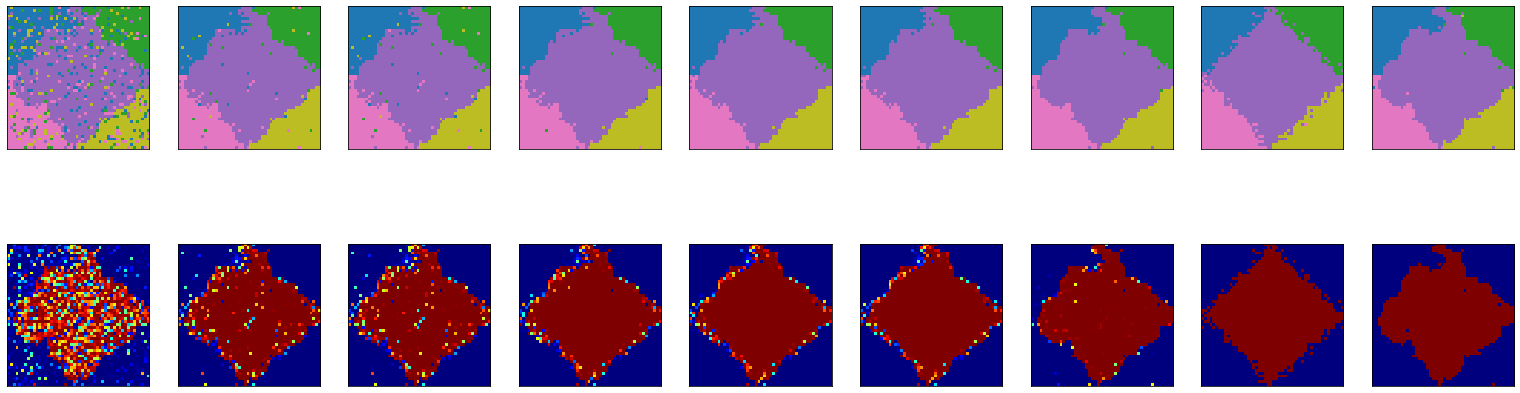

In [5]:
plot_U_maps(pt.stack(GM[0]), grid, title=['data'] + [m.name for m in Models] + ['true'])

plot_individual_Uhat(Models, Utrue[0:1], emloglik_train[0:1], grid, style='mixed')

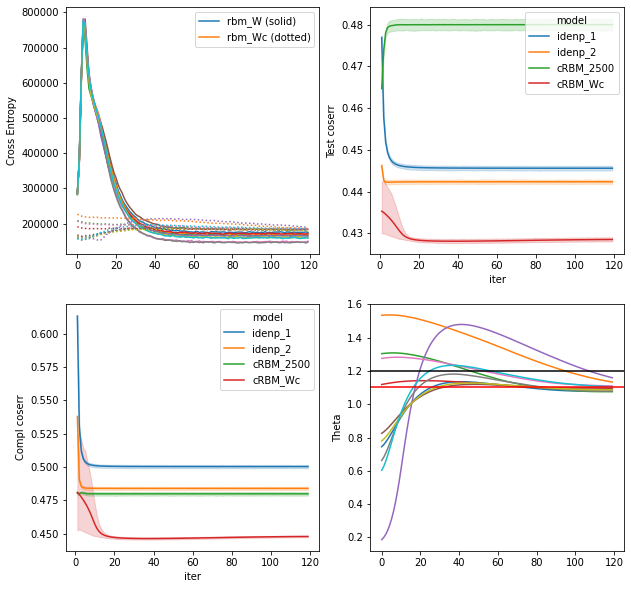

In [3]:
grid, DD, records, rbm, Models, Utrue, emloglik_train = simulation_2(K=5, width=50, num_subj=20, 
                                                                     batch_size=20, n_epoch=120, theta=1.2,
                                                                     theta_mu=240, emission='gmm', epos_iter=20, 
                                                                     eneg_iter=20, num_sim=10)

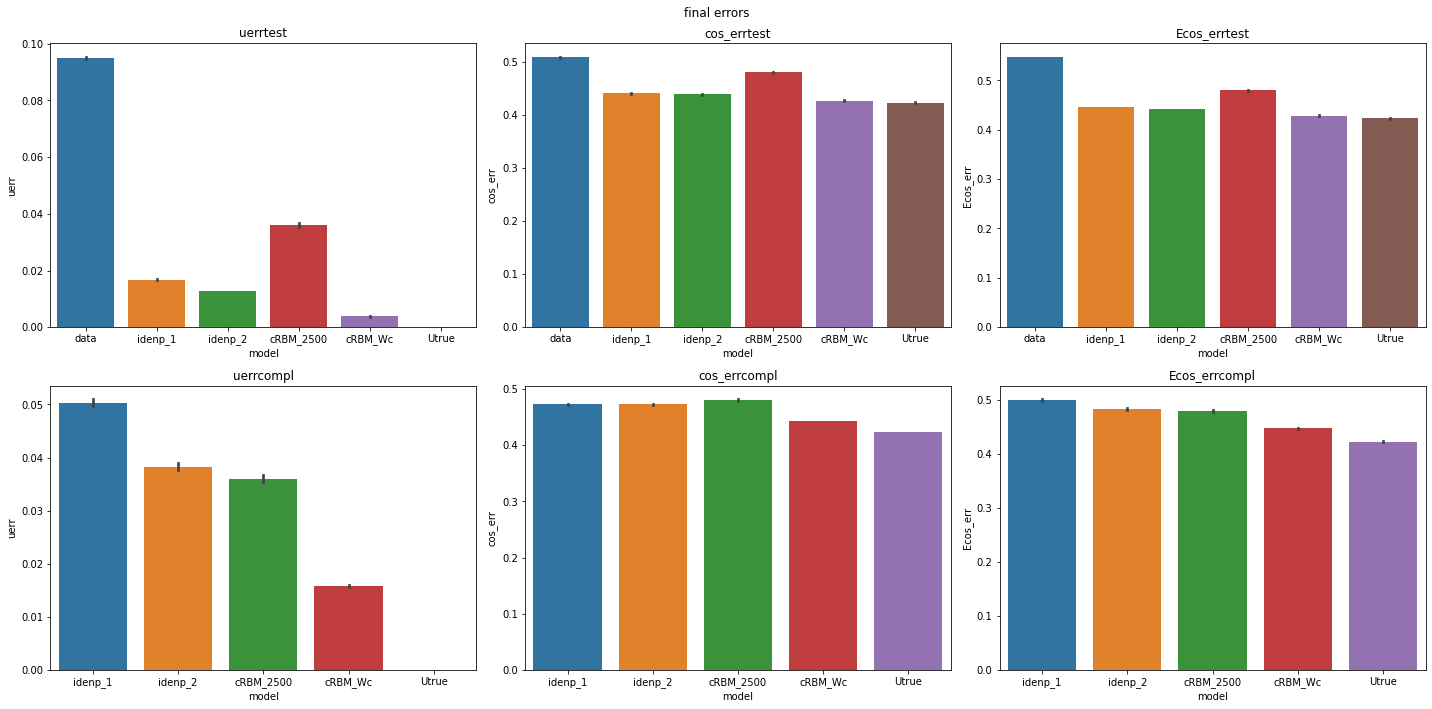

In [4]:
plot_evaluation(DD)

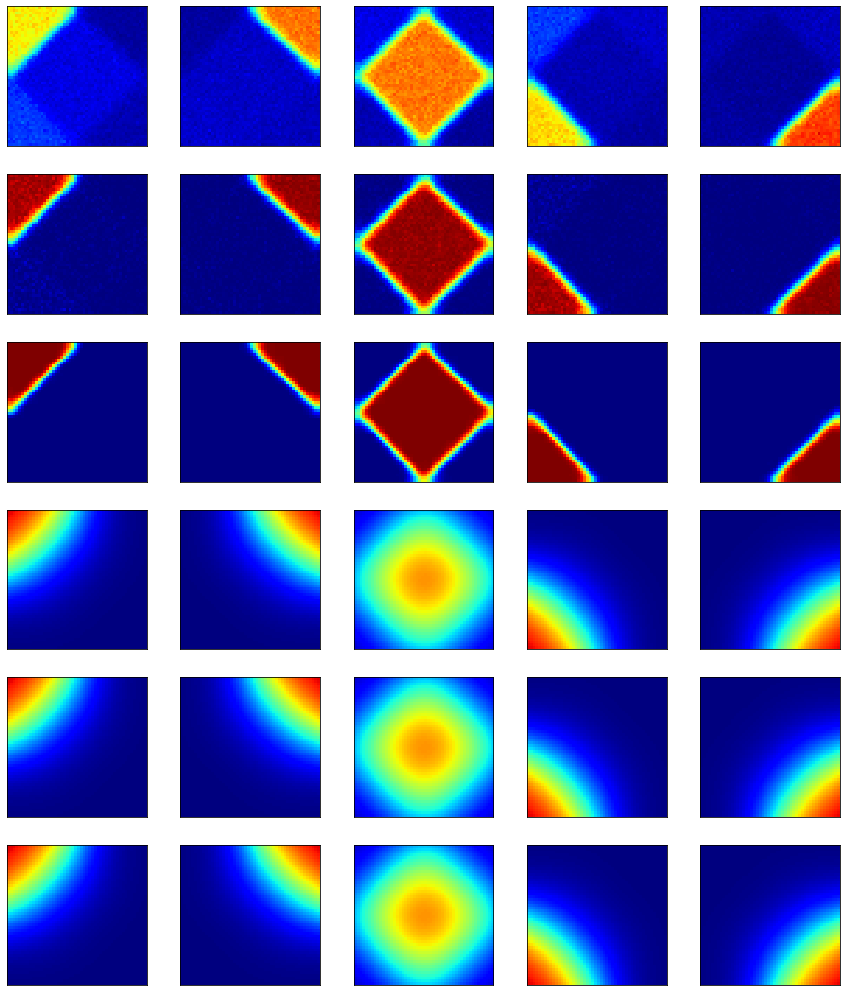

In [5]:
RecEmLog, RecLp1, RecLp2, RecBu1, RecBu2 = records[0], records[1], records[2], records[3], records[4]

plt.figure(figsize=(15,18))
plot_P_maps([RecEmLog.mean(dim=0), RecLp1.mean(dim=0), RecLp2.mean(dim=0),
             RecBu1.mean(dim=0), RecBu2.mean(dim=0), pt.softmax(rbm.bu, 0)],
            grid)
plt.show()

<Figure size 1080x360 with 0 Axes>

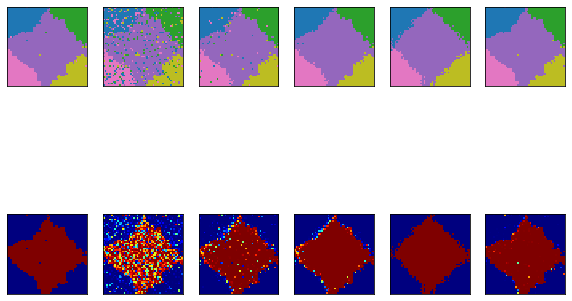

In [6]:
plt.figure(figsize=(15,5))
plot_individual_Uhat(Models, Utrue[0:1], emloglik_train[0:1],
                         grid, style='mixed')
plt.show()

## Speed comparison of vmf sampling

In [7]:
from sample_vmf import *
import time

tic = time.perf_counter()
for i in range(10):
    samples_old = rand_von_mises_fisher(pt.tensor([1.0,0.0,0.0]), pt.tensor(25), N=1000)
toc = time.perf_counter()
print(f'Sampling used {toc - tic:0.4f} seconds!')

tic = time.perf_counter()
for i in range(10):
    samples_new = random_VMF(np.array([1,0,0]), 25, size=1000)
toc = time.perf_counter()
print(f'Sampling used {toc - tic:0.4f} seconds!')

samples_old = samples_old.to('cpu').numpy()

Sampling used 17.9259 seconds!
Sampling used 0.0045 seconds!


In [12]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2,
                    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=["old vmf sampling", "new vmf sampling"])

fig.add_trace(go.Scatter3d(x=samples_old[:, 0], y=samples_old[:, 1], z=samples_old[:, 2],
                           mode='markers', marker=dict(size=3, opacity=0.7)),
                           row=1, col=1)

fig.add_trace(go.Scatter3d(x=samples_new[:, 0], y=samples_new[:, 1], z=samples_new[:, 2],
                           mode='markers', marker=dict(size=3, opacity=0.7)),
                           row=1, col=2)


fig.update_layout(
    scene1=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1]),
        aspectmode='cube'
    ),
    scene2=dict(
        xaxis=dict(range=[-1, 1]),
        yaxis=dict(range=[-1, 1]),
        zaxis=dict(range=[-1, 1])
    ),
    width=1000,
    height=600,
    title='3D Scatter Plots - VMF sampling'
)
fig.show()